# Initialization

In [ ]:
import os
import sys
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from pyspark.sql import SparkSession
from pyspark.sql.functions import log1p

from pyspark.ml import Pipeline

from pyspark.ml.regression import GeneralizedLinearRegression, RandomForestRegressor

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel

In [2]:
print(sys.executable)    # vérification
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

print(pyspark.__version__)

/Users/gaelleba/anaconda3/envs/sparkEnv/bin/python
3.5.4


# Start Spark session and open pre-treated dataset

In [3]:
# create a spark session
spark = SparkSession \
.builder \
.master("local") \
.config("spark.executor.memory", "8g") \
.config("spark.driver.memory", "8g") \
.config("spark.memory.fraction", "0.6") \
.config("spark.memory.storageFraction", "0.3") \
.config("spark.executor.cores", "4") \
.config("spark.sql.shuffle.partitions", "200") \
.config("spark.driver.extraJavaOptions", "-XX:ReservedCodeCacheSize=512m") \
.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/10 22:44:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/10 22:44:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
folder_models="regression_models_sample"
df_name='df_regression_sample_fullEmbed'

In [5]:
# Load the pre-treated dataset
df_reg = spark.read.parquet(f"{folder_models}/{df_name}")
df_reg.printSchema()
print("Features vector size:", df_reg.select("features").head()[0].size)

root
 |-- features: vector (nullable = true)
 |-- cit1year: integer (nullable = true)

Features vector size: 803


In [6]:
df_reg = df_reg.withColumn('log_cit1year', log1p(df_reg['cit1year']))
df_reg.show()

+--------------------+--------+------------------+
|            features|cit1year|      log_cit1year|
+--------------------+--------+------------------+
|[1.0,0.0,1.0,0.0,...|      11|2.4849066497880004|
|[1.0,0.0,0.0,0.0,...|       2|1.0986122886681096|
|[1.0,0.0,0.0,0.0,...|       7|2.0794415416798357|
|[1.0,0.0,0.0,0.0,...|       0|               0.0|
|[1.0,0.0,0.0,0.0,...|       5| 1.791759469228055|
|[1.0,0.0,0.0,0.0,...|      10|2.3978952727983707|
|[1.0,0.0,1.0,0.0,...|       2|1.0986122886681096|
|[1.0,0.0,0.0,0.0,...|       2|1.0986122886681096|
|[1.0,0.0,0.0,0.0,...|       8|2.1972245773362196|
|[1.0,0.0,0.0,0.0,...|       0|               0.0|
|[1.0,0.0,1.0,0.0,...|       6|1.9459101490553132|
|[1.0,0.0,1.0,0.0,...|      21| 3.091042453358316|
|[1.0,0.0,0.0,0.0,...|       3|1.3862943611198906|
|[1.0,0.0,1.0,0.0,...|       7|2.0794415416798357|
|[1.0,0.0,0.0,1.0,...|      19| 2.995732273553991|
|[1.0,0.0,1.0,0.0,...|       7|2.0794415416798357|
|[1.0,0.0,0.0,0.0,...|       3|

In [7]:
# Partitionner les données en apprentissage (80%) et test (20%)
partitions = df_reg.randomSplit([0.8, 0.2], seed=100)
train = partitions[0].cache()  # conservé en mémoire
test = partitions[1]

In [ ]:
train.write.mode("overwrite").parquet(f"{folder_models}/train_fullEmbed")
test.write.mode("overwrite").parquet(f"{folder_models}/test_fullEmbed")

# Regression models

## Generalized linear regression

In [ ]:

glr =GeneralizedLinearRegression(family="tweedie")\
    .setFeaturesCol("features")\
    .setLabelCol("cit1year")\
        
pipeline_glr = Pipeline().setStages([glr])

In [ ]:
# Construction de la grille de (hyper)paramètres utilisée pour grid search
paramGrid_glr = (ParamGridBuilder()
             .addGrid(glr.regParam, [0.001, 0.005, 0.01, 0.1, 0.5, 1.0])
             .addGrid(glr.maxIter, [50, 100, 200])
             .build())

cv_glr = CrossValidator().setEstimator(pipeline_glr) \
                     .setEstimatorParamMaps(paramGrid_glr) \
                     .setNumFolds(5) \
                     .setEvaluator(RegressionEvaluator(metricName="mae", labelCol="cit1year"))

cvGLRmodel = cv_glr.fit(train)

In [51]:
# Afficher les valeurs AUC obtenues pour les combinaisons de la grille
print(cvGLRmodel.avgMetrics)

# Afficher les meilleures valeurs pour les hyperparamètres
cvGLRmodel.getEstimatorParamMaps()[cvGLRmodel.avgMetrics.index(max(cvGLRmodel.avgMetrics))]

[16.123558067489455, 16.123558067489455, 16.123558067489455, 16.103598071222358, 16.103598071222358, 16.103598071222358, 16.07896477334721, 16.07896477334721, 16.07896477334721, 15.6869714919134, 15.6869714919134, 15.6869714919134, 14.580486055454628, 14.580486055454628, 14.580486055454628, 13.810050039718973, 13.810050039718973, 13.810050039718973]


{Param(parent='GeneralizedLinearRegression_f018256e76fd', name='regParam', doc='regularization parameter (>= 0).'): 0.001,
 Param(parent='GeneralizedLinearRegression_f018256e76fd', name='maxIter', doc='max number of iterations (>= 0).'): 50}

In [52]:
cvGLRmodel.write().overwrite().save(f"{folder_models}/cvGLR_tweedie_model_fullEmbed")

## Random forests

In [53]:
rf = RandomForestRegressor() \
              .setFeaturesCol("features") \
              .setLabelCol("cit1year")\
            .setSeed(100)

pipelineRF = Pipeline().setStages([rf])

In [ ]:
paramGrid_rf = ParamGridBuilder() \
                .addGrid(rf.numTrees, [25, 50, 100]) \
                .addGrid(rf.maxDepth, [2, 5, 10]) \
                .addGrid(rf.minInstancesPerNode, [2, 5, 10, 15])\
                .addGrid(rf.featureSubsetStrategy, ["sqrt", "log2"])\
                .build()

cv_rf = CrossValidator().setEstimator(pipelineRF) \
                           .setEstimatorParamMaps(paramGrid_rf) \
                           .setNumFolds(5) \
                           .setEvaluator(RegressionEvaluator(metricName="mae", labelCol="cit1year"))

cvRFmodel = cv_rf.fit(train)

25/02/09 17:30:19 WARN DAGScheduler: Broadcasting large task binary with size 1210.4 KiB
25/02/09 17:30:26 WARN DAGScheduler: Broadcasting large task binary with size 1080.9 KiB
25/02/09 17:30:34 WARN DAGScheduler: Broadcasting large task binary with size 1189.7 KiB
25/02/09 17:30:41 WARN DAGScheduler: Broadcasting large task binary with size 1066.4 KiB
25/02/09 17:30:48 WARN DAGScheduler: Broadcasting large task binary with size 1138.3 KiB
25/02/09 17:30:55 WARN DAGScheduler: Broadcasting large task binary with size 1034.3 KiB
25/02/09 17:31:01 WARN DAGScheduler: Broadcasting large task binary with size 1153.6 KiB
25/02/09 17:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1587.5 KiB
25/02/09 17:31:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/02/09 17:31:05 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/02/09 17:31:12 WARN DAGScheduler: Broadcasting large task binary with size 1132.9 KiB
25/02/09 17:31:13 WARN DAGS

In [62]:
# Afficher les valeurs AUC obtenues pour les combinaisons de la grille
print(cvRFmodel.avgMetrics)

# Afficher les meilleures valeurs pour les hyperparamètres
cvRFmodel.getEstimatorParamMaps()[cvRFmodel.avgMetrics.index(max(cvRFmodel.avgMetrics))]

[8.843729782308003, 8.820109797776757, 8.79170530920466, 8.815756238570495, 8.72450188889209, 8.797367100185387, 8.774548827079997, 8.803190751518192, 8.718704763372493, 8.758245985683217, 8.690868848468263, 8.754989861640425, 8.757459148032481, 8.804318044940064, 8.75813881920803, 8.783991137198075, 8.697915921950983, 8.748896485048968, 9.206553248796249, 9.058580609658113, 8.881578942304879, 8.907980468937007, 8.762888637056891, 8.746871785168038, 9.047007171294, 8.945488671693075, 8.803817728527426, 8.768284437878055, 8.649013598226393, 8.736114678186361, 8.98845986869651, 8.953358966462469, 8.82210281379367, 8.80228082746953, 8.693980882174461, 8.6646421508989, 9.636236447767804, 9.432821098029777, 9.036699566967712, 9.012356938276351, 8.798611730785757, 8.752774659585816, 9.401261472146718, 9.3109184847017, 8.900066518423388, 8.868732798620306, 8.671170196350982, 8.730737234572624, 9.34857507683044, 9.299403415871307, 8.928911356701978, 8.90126057584673, 8.692388680016398, 8.66291

{Param(parent='RandomForestRegressor_67274762f303', name='numTrees', doc='Number of trees to train (>= 1).'): 50,
 Param(parent='RandomForestRegressor_67274762f303', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10,
 Param(parent='RandomForestRegressor_67274762f303', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 2,
 Param(parent='RandomForestRegressor_67274762f303', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (u

In [ ]:
# Check the importance of features
best_RFmodel = cvRFmodel.bestModel.stages[-1]
feature_importances = best_RFmodel.featureImportances

# Transform the result into a DataFrame for visualization
importances_df = pd.DataFrame(list(zip(range(len(feature_importances)), feature_importances)), columns=['Feature Index', 'Importance'])
print(importances_df)

     Feature Index  Importance
0                0    0.001604
1                1    0.000000
2                2    0.000000
3                3    0.002450
4                4    0.007145
..             ...         ...
798            798    0.000000
799            799    0.000201
800            800    0.000000
801            801    0.000826
802            802    0.001400

[803 rows x 2 columns]


In [55]:
cvRFmodel.write().overwrite().save(f"{folder_models}/cvRF_model_fullEmbed")

# Comparaison des modèles sur les données de test

## Load models saved

In [ ]:
# Load the best models from the cross-validation
cvGLRmodel = CrossValidatorModel.load(f"{folder_models}/cvGLR_tweedie_model_fullEmbed")
cvRFmodel = CrossValidatorModel.load(f"{folder_models}/cvRF_model_fullEmbed")

## Calculate performance metrics

In [ ]:
# Define the models
models = {
    'LinearGM': cvGLRmodel,
    'RandomForest': cvRFmodel
}

# Define the evaluators
evaluators = {
    'MAE': RegressionEvaluator(metricName="mae", labelCol="cit1year"),
    'RMSE': RegressionEvaluator(metricName="rmse", labelCol="cit1year"),
    'R2': RegressionEvaluator(metricName="r2", labelCol="cit1year")
}

In [58]:
def evaluate_models(train, test, models, evaluators):
    
    results = []
    
    # Creation figure 'scatter plot'
    n=len(models)
    fig, axes = plt.subplots(1, n, figsize=(18, 6))

    for model_name, model in models.items():
        # Collect the best parameters from the cross-validation results and fit on the entire training set
        best_model = model.getEstimator().copy(model.bestModel.extractParamMap())
        best_model = best_model.fit(train)

        # Make predictions on the test data
        predictions_train = model.transform(train)
        predictions_test = model.transform(test)
        
        # Evaluate the predictions
        for metric_name, evaluator in evaluators.items():
            metrics_train = {
                'Model': model_name,
                'Dataset': 'Train',
                'Metric': metric_name,
                'Value': evaluator.evaluate(predictions_train)
            }
            metrics_test = {
                'Model': model_name,
                'Dataset': 'Test',
                'Metric': metric_name,
                'Value': evaluator.evaluate(predictions_test)
            }
            
            # Store the results
            results.append(metrics_train)
            results.append(metrics_test)
        
            # Scatter plot Réel VS Prediction
            predictions_scatter = predictions_test.select("cit1year", "prediction").toPandas()
            index = list(models.keys()).index(model_name)
            axes[index].scatter(predictions_scatter["cit1year"], predictions_scatter["prediction"], alpha=0.6, color='blue')
            axes[index].plot([min(predictions_scatter["cit1year"]), max(predictions_scatter["cit1year"])],
                        [min(predictions_scatter["cit1year"]), max(predictions_scatter["cit1year"])],
                        color='red', linestyle='--')  # Line for perfect prediction
            axes[index].set_title(f"Modèle de régression: {model_name}")
            axes[index].set_xlabel("Valeurs réelles")
            axes[index].set_ylabel("Valeurs prédites")
    
    plt.tight_layout()
    plt.show()
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

25/02/09 18:59:30 WARN Instrumentation: [0b45d7ae] regParam is zero, which might cause numerical instability and overfitting.
25/02/09 18:59:31 WARN Instrumentation: [0b45d7ae] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


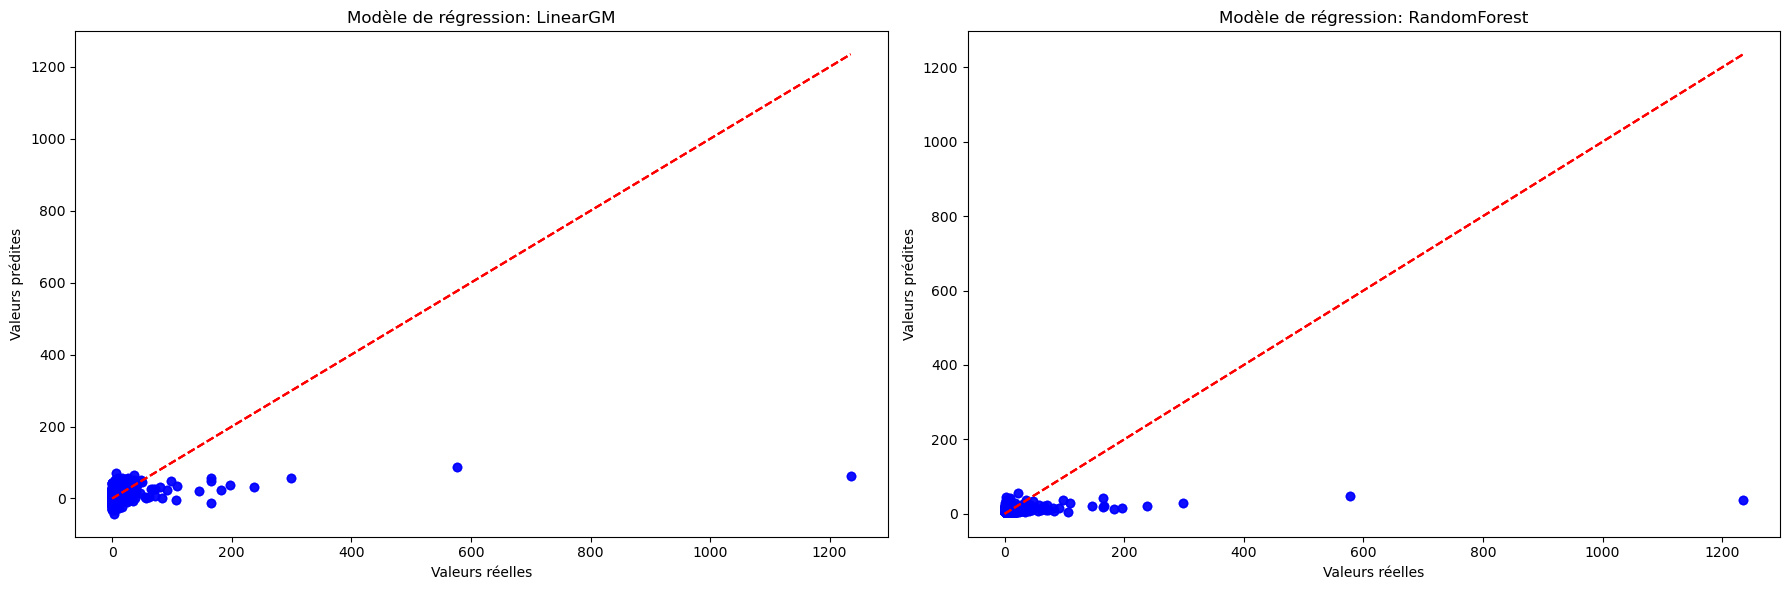

           Model Dataset Metric      Value
0       LinearGM   Train    MAE  11.266670
1       LinearGM    Test    MAE  13.386411
2       LinearGM   Train   RMSE  27.449014
3       LinearGM    Test   RMSE  41.992183
4       LinearGM   Train     R2   0.239051
5       LinearGM    Test     R2   0.063767
6   RandomForest   Train    MAE   7.826393
7   RandomForest    Test    MAE   8.845263
8   RandomForest   Train   RMSE  26.076788
9   RandomForest    Test   RMSE  41.781630
10  RandomForest   Train     R2   0.313232
11  RandomForest    Test     R2   0.073132


In [ ]:
# Evaluate the models
results_df = evaluate_models(train, test, models, evaluators)
print(results_df)

In [60]:
results_df.to_csv(f"{folder_models}/results_sample_fullEmbed.csv", index=False)

### Bar Plots using performance metrics

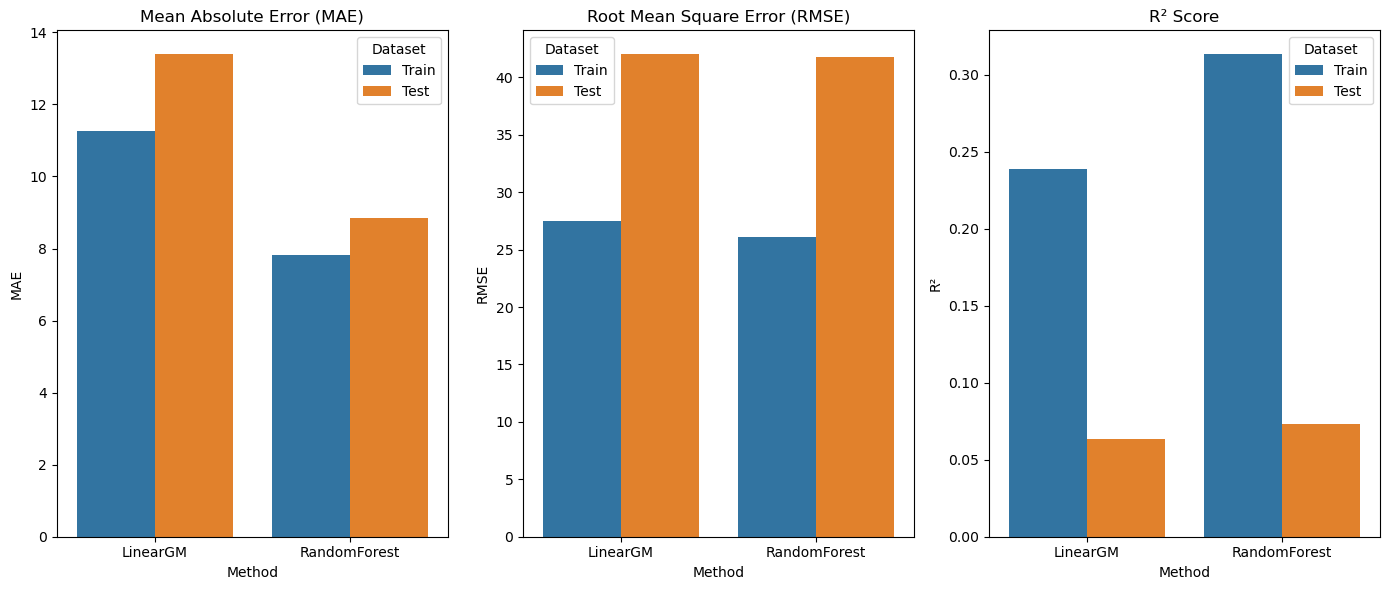

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Bar plot -- MAE
sns.barplot(data = results_df[results_df['Metric'] == 'MAE'], x = "Model", y = "Value", hue = "Dataset", ax = axes[0])
axes[0].set_title("Mean Absolute Error (MAE)")
axes[0].set_ylabel("MAE")
axes[0].set_xlabel("Method")

# Bar plot -- RMSE
sns.barplot(data = results_df[results_df['Metric'] == 'RMSE'], x = "Model", y = "Value", hue = "Dataset", ax = axes[1])
axes[1].set_title("Root Mean Square Error (RMSE)")
axes[1].set_ylabel("RMSE")
axes[1].set_xlabel("Method")

# Bar plot -- R2
sns.barplot(data = results_df[results_df['Metric'] == 'R2'], x = "Model", y = "Value", hue = "Dataset", ax = axes[2])
axes[2].set_title("R² Score")
axes[2].set_ylabel("R²")
axes[2].set_xlabel("Method")

plt.tight_layout()
plt.show()
